# **Pulsar Star Project**

### Group 144

Authors:
* Chadd Hennig, 37879814
* Jenni Tong, 23988835
* Jincheng Hong, 16879926
* Susan Liu, 25691544




## Introduction

Pulsar detection is a significant endeavour within astrophysics, as it provides scientists with a deeper understanding of the cosmos. Specifically, the discovery of pulsars provide information about certain timelines in the universe, as well as information about the inter-stellar medium itself. Pulsars are the remains of a collapsed star— also known as neutron stars. Such neutron stars produce radio emissions, which lies as the basis for pulsar discovery. Pulsar rotation results in a distinct radio emission pattern, which instruments on earth can then detect to confirm the pulsar’s existence. The issue, however, is that there are various celestial objects that produce detectable radio emissions.

Therefore, this project analyzes the question of classifying whether or not certain emission patterns are actually from pulsars.  

Through the cleaning, wrangling, and visualization of the HTRU2 data set, we will be able to clearly see which pulsar candidates are truly pulsars.

## Preliminary Exploratory Data Analysis

In [1]:
#load library
library(tidyverse)
library(repr)
library(tidymodels)

#set seed
set.seed(144)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Read in the data set
pulsar <- read_csv('https://raw.githubusercontent.com/susanyliu/dsci100-project144/main/data/HTRU_2.csv', col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Find the column names in "Readme" file and add names

In [3]:
#add column names
colnames(pulsar) <- c('Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 
                      'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'class')

Note that the class column is of double type, so we changed the column `class` into factor

In [4]:
# changed the column "class" into factor
pulsar <- pulsar |>
    mutate(class = as_factor(class))

Now the data is clean. We split it into training and testing data with 75% being training data.

In [5]:
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

print the cleaned data

In [6]:
#print
pulsar

Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


### Summarize the Data

To have a overview of our data(training data), we  
1. summarized the mean value for each predictor  
2. counted the number of observations for each class.  

Note: there is no missing values.

In [7]:
#summarize and create a table
predictor_mean <- pulsar_train %>% 
    group_by(class) %>% 
    summarize(Profile_mean = mean(Profile_mean) , Profile_stdev = mean(Profile_stdev),
              Profile_skewness = mean(Profile_skewness),Profile_kurtosis = mean(Profile_kurtosis),
              DM_mean = mean(DM_mean),n=n() )

Let's now take a look at our summarized table. 
Here, columns 2-6 represent the mean value of that variable 
(e.g. the data column `Profile_stdev` represent the mean value of Profile standard deviation from all observations in the class).  
Column `n` represents the number of observations in the class.

In [8]:
predictor_mean

class,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,116.56174,47.32295,0.2111174,0.378781,8.722467,12235
1,56.93468,38.70407,3.1311589,15.618123,50.268911,1188


### Visualize the Data

To find which variables are relevant and distinguish whether it is a pulsar star (i.e. the class being 0 or 1), 
we created several scatter plots between variables and colored it according to their different classes.

In [9]:
#plot to see related variables
plot1.2 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_stdev, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Mean of the integrated profile', y = 'Standard deviation of the integrated profile', color = "Is pulsar?")

plot1.3 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

plot1.4 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Mean of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot2.3 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= Profile_skewness, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Standard deviation of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

plot2.4 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= Profile_kurtosis, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Standard deviation of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot2.5 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= DM_mean, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Standard deviation of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot3.4 <- pulsar_train|>
    ggplot(aes(x = Profile_skewness, y = Profile_kurtosis, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Excess kurtosis of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot3.5 <- pulsar_train|>
    ggplot(aes(x = Profile_skewness, y= DM_mean, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Excess kurtosis of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot4.5 <- pulsar_train|>
    ggplot(aes(x = Profile_kurtosis, y = DM_mean, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Skewness of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot5.6 <- pulsar_train|>
    ggplot(aes(x = DM_mean, y= DM_stdev, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Mean of the DM-SNR curve', y = 'Standard deviation of the DM-SNR curve', color = "Is pulsar?")

plot6.7 <- pulsar_train|>
    ggplot(aes(x = DM_stdev, y= DM_skewness, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Standard deviation of the DM-SNR curve', y = 'Excess kurtosis of the DM-SNR curve', color = "Is pulsar?")

plot7.8 <- pulsar_train|>
    ggplot(aes(x = DM_skewness, y= DM_kurtosis, color = class, alpha = 0.1))+
    geom_point()+
    labs(x = 'Excess kurtosis of the DM-SNR curve', y = 'Skewness of the DM-SNR curve', color = "Is pulsar?")

We analyzed the plots above and found that variables `Profile_mean`, `Profile_stdev`, `Profile_skewness`, `Profile_kurtosis`, `DM_mean` is strongly related to the variable `class`,
for that the plot involving these variables show a strong distinction between pulsar star and non-pulsar star.  

Below are some of the plots that shows this relationship.

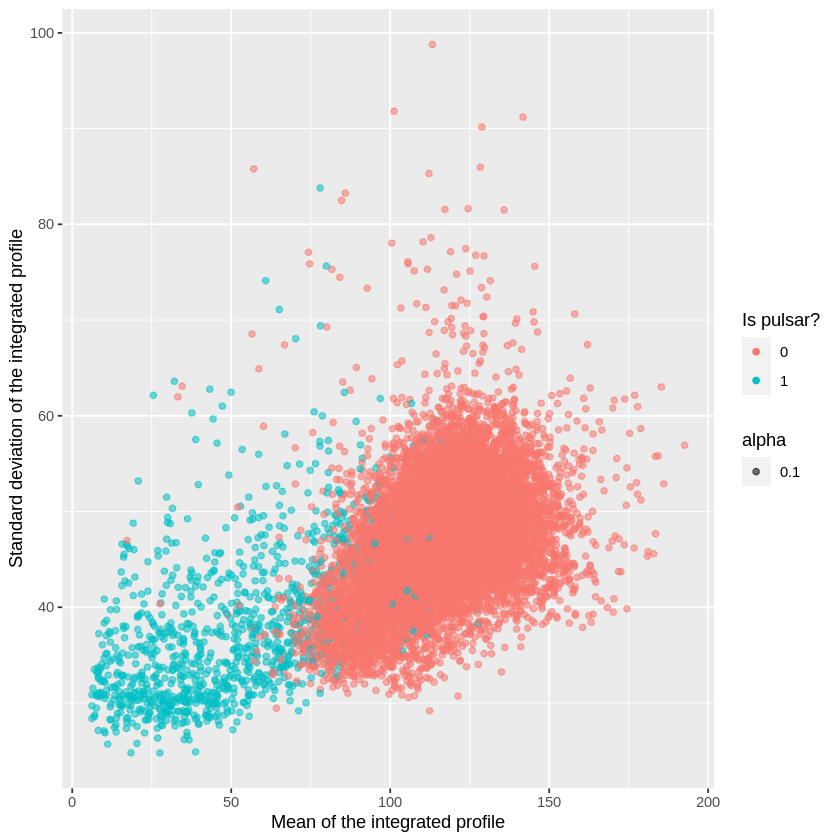

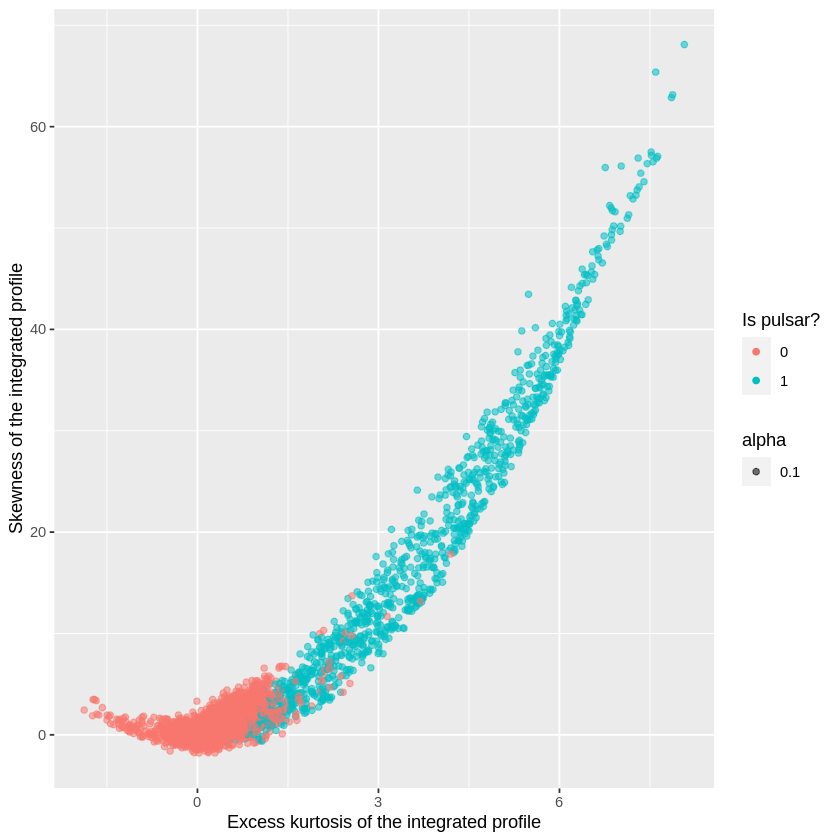

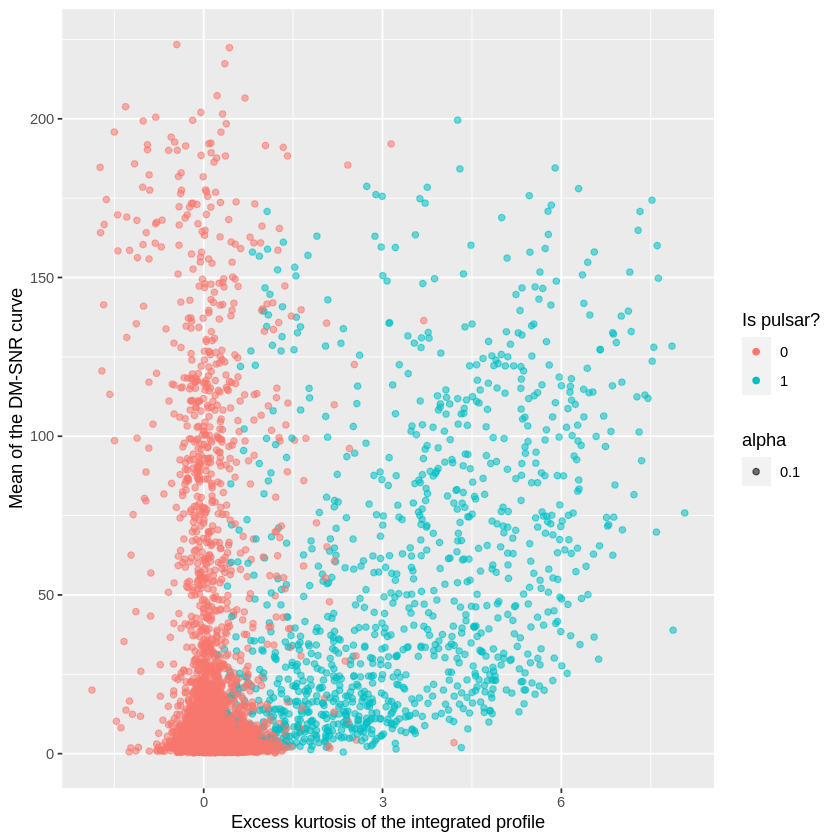

In [10]:
plot1.2
plot3.4
plot3.5

From these three plots, we can see that the distinction between classes is quite obvious, with each class in separate parts of the plot. Therefore, we are going to choose `Profile_mean`, `Profile_stdev`, `Profile_skewness`, `Profile_kurtosis`, `DM_mean`as predictors.

## Methods

Use `Profile_mean`, `Profile_stdev`, `Profile_skewness`, `Profile_kurtosis`, `DM_mean` as predictors.

Steps: 

1. Create Recipe  
    Create a recipe with `class` ~ predictors above.  
   Use `step_scale()` and `step_center()` to scale and centre the 5 variables.

    
2. Cross-Validate the data  
    Use the training data to create a k-nearest-neighbor model that performs a 5-fold cross-validation.
    
    
3. Workflow to get ideal *K*  
    Create a workflow and fit the 5-fold data in to choose an ideal *K*.

4. Workflow and Fit  
   Create a workflow to fit all training data.
    
5. Use our classifier to predict the testing data `pulsar_test`

6. Evaluate our model  
   Create a table to show the accuracy of our model using the `metrics()`, then compare.
    

### Methods - Visualization

Use several scatterplots with each containing 2 predictors to visualize our results, and include a legend that shows which color represents pulsars and non-pulsars. Also, use two colors to show the areas of pulsar and non-pulsar.

## Expected Outcomes and Significance

The classification of these candidates will provide a glimpse into the reality of pulsar existence, and more precisely pulsar abundance. We will be able to identify what proportion of these candidates are actually pulsars. We predict that there will be more candidates that aren't pulsars than those that are. This is due to the overwhelming number of interstellar objects which release radio emissions.  



Regardless of what the data proves to be true, the significance of the outcome will be crucial in making further progress in the astrophysics field. Once candidates are classified as pulsars, scientists can hone in on these samples and learn more about their origins and behaviour — providing information about stellar collapse and even about planets beyond the solar system we live in.  

With this information, further research may address certain questions regarding pulsars. Questions may include: what relationship exists between pulsar existence and extraterrestrial life? What factors most accurately indicate between pulsars and non-pulsars? Ultimately, the findings of this data classification will be significant in the realm of astrophysics.

In [11]:
set.seed(144)
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)
pulsar_recipe <- recipe(class~ Profile_mean, Profile_stdev, Profile_skewness, Profile_kurtosis, DM_mean, data = pulsar_train) |>
     step_scale(all_predictors()) |>
     step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

knn_results <- workflow() |>
     add_recipe(pulsar_recipe) |>
     add_model(knn_spec) |>
     tune_grid(resamples = pulsar_vfold, grid = 30) |>
     collect_metrics()

accuracies <- knn_results |>
     filter(.metric == "accuracy")

[1] "We choose to set the value of k to 13 in our classification model, as it gives a high accuracy of around 96%, and either increasing or decresing from 13 would not affect the accuracy by too much, which suggest that setting neighbors equal to 13 is the optimal choice."


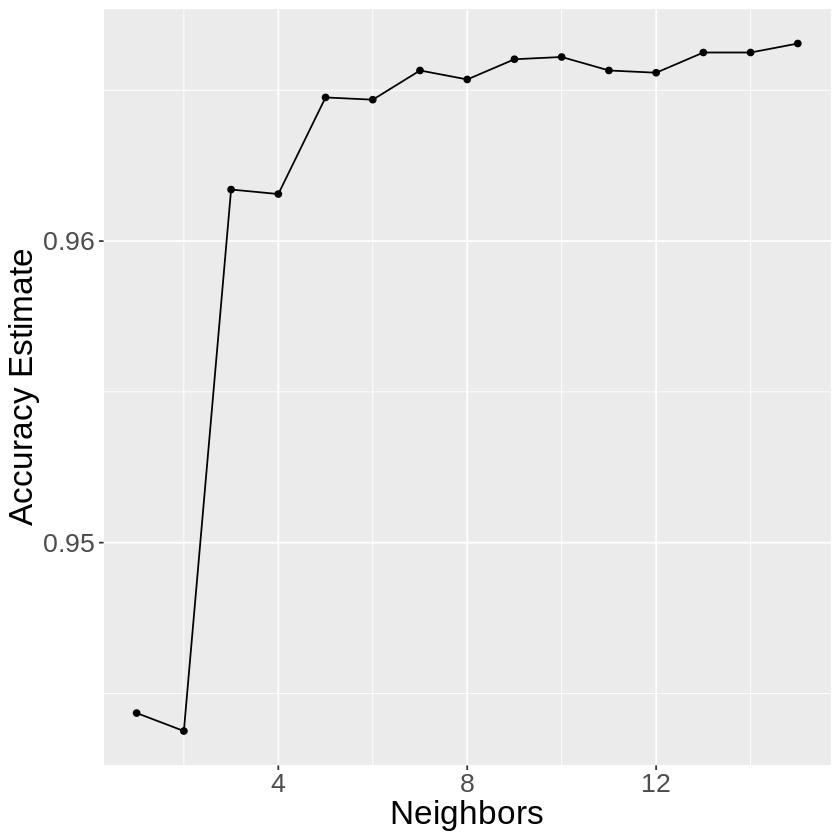

In [55]:
cross_val_plot <- accuracies |>
       ggplot(aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       theme(text = element_text(size = 20))
cross_val_plot

print("We choose to set the value of k to 13 in our classification model, as it gives a high accuracy of around 96%, and either increasing or decresing from 13 would not affect the accuracy by too much, which suggest that setting neighbors equal to 13 is the optimal choice.")

In [13]:
set.seed(144)
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
       set_engine("kknn") |>
       set_mode("classification")

pulsar_fit <- workflow() |>
       add_recipe(pulsar_recipe) |>
       add_model(pulsar_spec) |>
       fit(data=pulsar_train)

In [14]:
pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
          bind_cols(pulsar_test)
pulsar_predictions

pulsar_metrics <- pulsar_predictions |>
          metrics(truth = class, estimate = .pred_class)     
pulsar_metrics

pulsar_conf_mat <- pulsar_predictions|>
          conf_mat(truth = class, estimate = .pred_class)
pulsar_conf_mat

.pred_class,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,107.25000,52.62708,0.45268802,0.17034738,2.3319398,14.486853,9.001004,107.97251,0
0,134.96094,49.55433,-0.13530383,-0.08046960,10.6964883,41.342044,3.893934,14.13121,0
0,117.94531,45.50658,0.32543756,0.66145946,2.8361204,23.118350,8.943212,82.47559,0
0,109.64062,49.01765,0.13763583,-0.25669978,1.5083612,12.072901,13.367926,223.43842,0
0,110.10938,41.31817,0.09486040,0.68311261,1.0100334,13.026275,14.666511,231.20414,0
0,147.83594,53.62264,-0.13107960,-0.28885117,2.6923077,17.080881,8.849178,92.20175,0
0,107.87500,37.33066,0.49600476,1.48181586,1.1739130,12.016913,14.534290,252.69474,0
0,113.54688,49.50029,0.13000120,-0.20283903,2.4071906,14.422051,9.310343,113.68747,0
0,119.33594,47.50695,0.22031676,0.64571773,0.7926421,9.540907,18.766540,441.51334,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9635754
kap,binary,0.7783046


          Truth
Prediction    0    1
         0 3990  129
         1   34  322

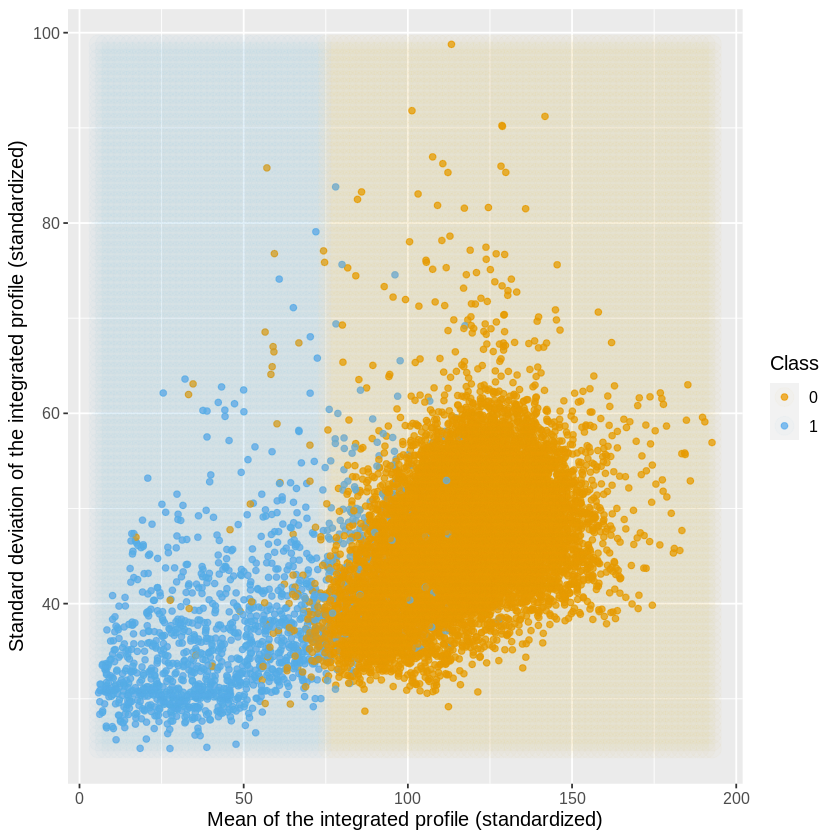

In [41]:
are_grid <- seq(min(pulsar$Profile_mean), 
                max(pulsar$Profile_mean), 
                length.out = 100)
smo_grid <- seq(min(pulsar$Profile_stdev), 
                max(pulsar$Profile_stdev), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Profile_mean = are_grid, 
                                Profile_stdev = smo_grid))

knnPredGrid <- predict(pulsar_fit, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
rename(class=.pred_class)



mean_stdev_plot <- ggplot() +
  geom_point(data=pulsar, mapping = aes(x = Profile_mean, y = Profile_stdev, color = class),
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Profile_mean, 
                           y = Profile_stdev, 
                           color = class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Class", 
       x = "Mean of the integrated profile (standardized)", 
       y = "Standard deviation of the integrated profile (standardized)") +
  scale_color_manual(labels = c(0,1), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
mean_stdev_plot

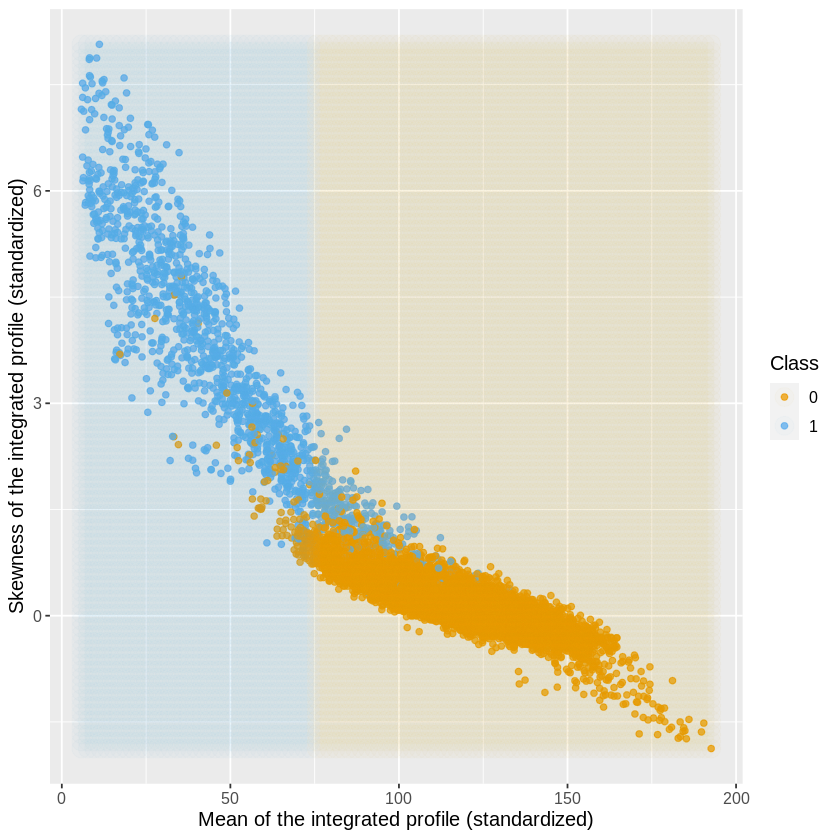

In [42]:
are_grid1 <- seq(min(pulsar$Profile_mean), 
                max(pulsar$Profile_mean), 
                length.out = 100)
smo_grid1 <- seq(min(pulsar$Profile_skewness), 
                max(pulsar$Profile_skewness), 
                length.out = 100)
asgrid1 <- as_tibble(expand.grid(Profile_mean = are_grid1, 
                                Profile_skewness = smo_grid1))

knnPredGrid1 <- predict(pulsar_fit, asgrid1)

prediction_table1 <- bind_cols(knnPredGrid1, asgrid1) |> 
rename(class=.pred_class)

mean_skewness_plot <- ggplot() +
  geom_point(data = pulsar, 
             mapping = aes(x = Profile_mean, y = Profile_skewness, color = class),
             alpha = 0.75) +
  geom_point(data = prediction_table1, 
             mapping = aes(x = Profile_mean, 
                           y = Profile_skewness, 
                           color = class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Class", 
       x = "Mean of the integrated profile (standardized)", 
       y = "Skewness of the integrated profile (standardized)") +
  scale_color_manual(labels = c(0,1), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
mean_skewness_plot

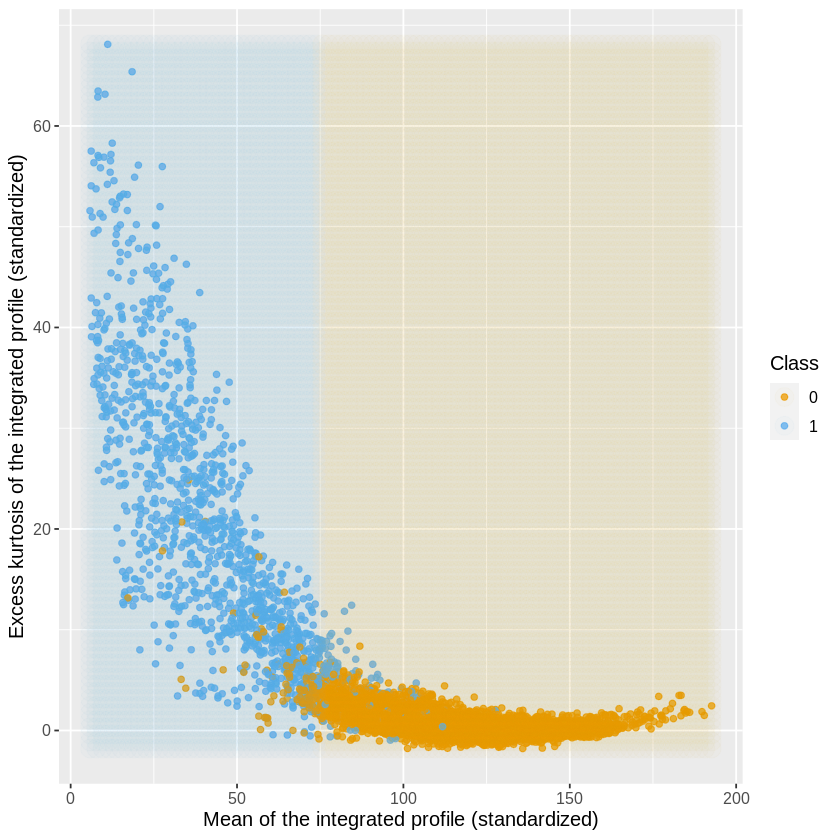

In [43]:
are_grid2 <- seq(min(pulsar$Profile_mean), 
                max(pulsar$Profile_mean), 
                length.out = 100)
smo_grid2 <- seq(min(pulsar$Profile_kurtosis), 
                max(pulsar$Profile_kurtosis), 
                length.out = 100)
asgrid2 <- as_tibble(expand.grid(Profile_mean = are_grid2, 
                                Profile_kurtosis = smo_grid2))

knnPredGrid2 <- predict(pulsar_fit, asgrid2)

prediction_table2 <- bind_cols(knnPredGrid2, asgrid2) |> 
rename(class=.pred_class)

mean_kurtosis_plot <- ggplot() +
  geom_point(data = pulsar, 
             mapping = aes(x = Profile_mean, y = Profile_kurtosis, color = class),
             alpha = 0.75) +
  geom_point(data = prediction_table2, 
             mapping = aes(x = Profile_mean, 
                           y = Profile_kurtosis, 
                           color = class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Class", 
       x = "Mean of the integrated profile (standardized)", 
       y = "Excess kurtosis of the integrated profile (standardized)") +
  scale_color_manual(labels = c(0,1), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
mean_kurtosis_plot

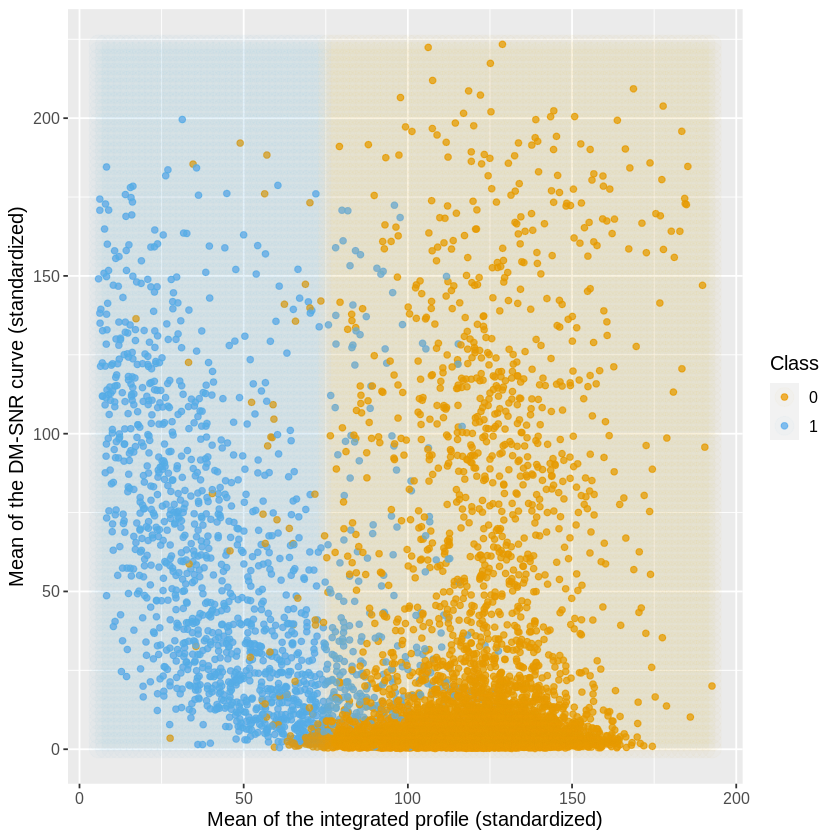

In [51]:
are_grid3 <- seq(min(pulsar$Profile_mean), 
                max(pulsar$Profile_mean), 
                length.out = 100)
smo_grid3 <- seq(min(pulsar$DM_mean), 
                max(pulsar$DM_mean), 
                length.out = 100)
asgrid3 <- as_tibble(expand.grid(Profile_mean = are_grid3, 
                                DM_mean = smo_grid3))

knnPredGrid3 <- predict(pulsar_fit, asgrid3)

prediction_table3 <- bind_cols(knnPredGrid3, asgrid3) |> 
rename(class=.pred_class)

mean_DM_mean_plot <- ggplot() +
  geom_point(data = pulsar, 
             mapping = aes(x = Profile_mean, y = DM_mean, color = class),
             alpha = 0.75) +
  geom_point(data = prediction_table3, 
             mapping = aes(x = Profile_mean, 
                           y = DM_mean, 
                           color = class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Class", 
       x = "Mean of the integrated profile (standardized)", 
       y = "Mean of the DM-SNR curve (standardized)") +
  scale_color_manual(labels = c(0,1), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
mean_DM_mean_plot

In [53]:
are_grid4 <- seq(min(pulsar$Profile_skewness), 
                max(pulsar$Profile_skewness), 
                length.out = 100)
smo_grid4 <- seq(min(pulsar$Profile_stdev), 
                max(pulsar$Profile_stdev), 
                length.out = 100)
asgrid4 <- as_tibble(expand.grid(Profile_skewness = are_grid4, 
                                Profile_stdev = smo_grid4))

knnPredGrid4 <- predict(pulsar_fit, asgrid4)

prediction_table4 <- bind_cols(knnPredGrid4, asgrid4) |> 
rename(class=.pred_class)

skewness_stdev_plot <- ggplot() +
  geom_point(data=pulsar, mapping = aes(x = Profile_skewness, y = Profile_stdev, color = class),
             alpha = 0.75) +
  geom_point(data = prediction_table4, 
             mapping = aes(x = Profile_skewness, 
                           y = Profile_stdev, 
                           color = class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Class", 
       x = "Mean of the integrated profile (standardized)", 
       y = "Standard deviation of the integrated profile (standardized)") +
  scale_color_manual(labels = c(0,1), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))
skewness_stdev_plot

ERROR: [1m[33mError[39m in [1m[1m`validate_column_names()`:[22m
[33m![39m The following required columns are missing: 'Profile_mean'.
